In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import pathlib 
import os

import torch
from torch import nn
from torch.utils.data import DataLoader
device = "cuda" if torch.cuda.is_available() else "cpu"

import PT_files.save_load as sl
from DnCNN_NP.layers  import relu

import time 
from collections import OrderedDict

# Load weights, data, and visualization functions

In [2]:
PATH = pathlib.Path(os.getenv('PSCRATCH'))
DATA = PATH / 'DESI_dn' /'Model_params'
assert DATA.exists()
name = '6k_model_wb_e800_lys20_58feat.pth'

# weights = np.load(DATA / name)
weights = torch.load(str(DATA / name))


#Load the actual data that we're working on & print the shape of this data
test_data = sl.NERSC_load('test_data_40%_6000.npy')
sample = test_data[0]
print('Shape of test set=', sample.shape)

Shape of test set= (108, 1, 6000, 6000)


In [ ]:
print(weights['layers.0.0.weight'].shape)
print(weights['layers.1.0.weight'].shape)

In [3]:
def pytorch_numpy_comparison(input_data,
                             pytorch_output,
                             numpy_output,
                             sample_idx,
                             start,
                             end,
                             conv = True,
                             FFT = True):
    if conv == True:
    
        if FFT == True:

            fig, ax = plt.subplots(1, 3, figsize=(24,20))
            vmin, vmax = np.percentile(input_data[sample_idx], (1,99))

            ax[0].imshow(input_data[sample_idx][0][start:end, start:end],vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
            ax[0].axis('off')
            ax[0].set_title('Input Sample', fontsize=30)
            ax[1].imshow(pytorch_output[sample_idx][0][start:end, start:end], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
            ax[1].axis('off')
            ax[1].set_title('Pytorch Conv', fontsize=30)
            ax[2].imshow(numpy_output[sample_idx][0][start:end, start:end], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
            ax[2].axis('off')
            ax[2].set_title('Numpy Conv (FFT Conv as Corr)', fontsize=30)

        else:

            fig, ax = plt.subplots(1, 3, figsize=(24,20))
            vmin, vmax = np.percentile(input_data[sample_idx], (1,99))

            ax[0].imshow(input_data[sample_idx][0][start:end, start:end],vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
            ax[0].axis('off')
            ax[0].set_title('Input Sample', fontsize=30)
            ax[1].imshow(pytorch_output[sample_idx][0][start:end, start:end], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
            ax[1].axis('off')
            ax[1].set_title('Pytorch Conv', fontsize=30)
            ax[2].imshow(numpy_output[sample_idx][0][start:end, start:end], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
            ax[2].axis('off')
            ax[2].set_title('Numpy Conv (Corr)', fontsize=30)
    
    else:
        
        # NOTE: This isn't using vmin/vmax due to the plots
        # of np_BatchNorm2d & nn.BatchNorm2d being washed out
        fig, ax = plt.subplots(1, 3, figsize=(24,20))
        # vmin, vmax = np.percentile(numpy_output[sample_idx], (1,99))

        ax[0].imshow(input_data[sample_idx][0][start:end, start:end], origin='lower', interpolation='none')
        ax[0].axis('off')
        ax[0].set_title('Input', fontsize=30)
        ax[1].imshow(pytorch_output[sample_idx][0][start:end, start:end], origin='lower', interpolation='none')
        ax[1].axis('off')
        ax[1].set_title('Pytorch BatchNorm', fontsize=30)
        ax[2].imshow(numpy_output[sample_idx][0][start:end, start:end], origin='lower', interpolation='none')
        ax[2].axis('off')
        ax[2].set_title('Numpy BatchNorm', fontsize=30)

##### Other version of plotting function

In [4]:
# def pytorch_numpy_comparison(input_data,
#                              pytorch_output,
#                              numpy_output,
#                              sample_idx,
#                              start,
#                              end,
#                              FFT = True):
    
#     if FFT == True:
    
#         fig, ax = plt.subplots(1, 3, figsize=(24,20))
#         vmin, vmax = np.percentile(input_data[sample_idx], (1,99))

#         ax[0].imshow(pytorch_output[sample_idx][0][start:end, start:end], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
#         ax[0].axis('off')
#         ax[0].set_title('Pytorch Conv', fontsize=30)
#         ax[1].imshow(input_data[sample_idx][0][start:end, start:end],vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
#         ax[1].axis('off')
#         ax[1].set_title('Input Sample', fontsize=30)
#         ax[2].imshow(numpy_output[sample_idx][0][start:end, start:end], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
#         ax[2].axis('off')
#         ax[2].set_title('Numpy Conv (FFT Conv as Corr)', fontsize=30)
        
#     else:
        
#         fig, ax = plt.subplots(1, 3, figsize=(24,20))
#         vmin, vmax = np.percentile(input_data[sample_idx], (1,99))

#         ax[0].imshow(pytorch_output[sample_idx][0][start:end, start:end], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
#         ax[0].axis('off')
#         ax[0].set_title('Pytorch ', fontsize=30)
#         ax[1].imshow(input_data[sample_idx][0][start:end, start:end],vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
#         ax[1].axis('off')
#         ax[1].set_title('Input Sample', fontsize=30)
#         ax[2].imshow(numpy_output[sample_idx][0][start:end, start:end], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
#         ax[2].axis('off')
#         ax[2].set_title('Numpy Conv (Corr)', fontsize=30)

# Testing speeds of numpy implementation of the convolutional layer

Load `np_Conv2d` but using scipy fft convolution instead of scipy cross correlate for speed reasons

In [5]:
def fft_np_Conv2d(input_data, weights_dict, prefix, stride=1, padding="same", dilation=1):
    """
    Numpy implementation of the PyTorch Conv2d layer that uses the 
    learned PyTorch weights in the model.
    
    Parameters:
    -----------
    input_data: nd.array
        Input data of shape '(batch_size, in_channels, height, width)'
    weights_dict: OrderedDict
        weights_dict['weight']: torch.Tensor
            Weights tensor of shape '(out_channels, in_channels, kernel_size[0], kernel_size[1])'
        weights_dict['bias']: torch.Tensor
            Bias tensor of shape '(out_channels)'
    stride: int, optional
        The number of entries by which the filter is moved at each step.
        Defaults to 1
    padding: str, optional
        What padding strategy to use for this conv layer. Defaults to "same",
        which pads the layer such that the output has the same height and width
        as the input when the stride = 1. Specifically makes output of
        scipy.correlate2d have same shape as in1. An alternative option is "valid",
        which means no padding is done and the output has smaller dimensions
        than the input.
    dilation: int, optional
        Spacing between kernel elements.
        Defaults to 1.
     
        
    Returns:
    --------
    output: nd.array
        Array output of the convolution step with shape
        `(batch_size, out_channels, out_height, out_width)`.
    
    """
    
        
    # Checking to see if a single sample or a batch of samples is given.
    # If batch take the batch_size, in_channels, H, and W
    # If single sample is given reshape so the values above can be calculated
    dimensions_start = time.perf_counter()
    if len(input_data.shape) == 4:
    
        batch_size, input_channels, height, width = input_data.shape # (N, Cin, Hin, Win)
        
    elif len(input_data.shape) == 3:
        
        input_data = input_data.reshape((1, 1, 6000 , 6000))
        batch_size, input_channels, height, width = input_data.shape # (N, Cin, Hin, Win)
        
    dimensions_end = time.perf_counter()
    print('Getting input dimensions takes', dimensions_end-dimensions_start, 'seconds')

    # Load the weights and biases needed for a convolution
    # then take off gpu memory, move to CPU memory,
    # and lastly transform to numpy
    loading_start = time.perf_counter()
    weight = weights_dict[str(prefix) + 'weight']
    weight = weight.detach().cpu().numpy()
    bias = weights_dict[str(prefix) + 'bias']
    bias = bias.detach().cpu().numpy()
    
    # Calculate the kernel size and output channels from
    # the loaded weights from above
    kernel_size = weight[0][0].shape
    output_channels = len(weight)
    loading_end = time.perf_counter()
    print('Loading the weights takes', loading_end-loading_start, 'seconds')
    
    # Convert string padding into numerical padding
    # Using strings allow for one variable to account for padding & mode (see signal.fftconvolve)
    out_dimensions_start = time.perf_counter()
    mode = padding
    if mode == "same":
        padding = 1
    elif mode == "valid":
        padding = 0
    
    # Calculations for the output H and W dimensions
    height_out = ((height + (2*padding) - dilation * (kernel_size[0] - 1) - 1) / stride) + 1
    height_out = int(height_out)
    width_out = ((width + (2*padding) - dilation * (kernel_size[1] - 1) - 1) / stride) + 1
    width_out = int(width_out)

    # Create empty array of correct output dimensions
    output = np.empty((batch_size, output_channels, height_out, width_out))
    out_dimensions_end = time.perf_counter()
    print('Getting output dimensions takes', out_dimensions_end-out_dimensions_start, 'seconds')
    
    # Place the convolved elements into the newly created 
    # empty array of correct output dimensions
    loop_start = time.perf_counter()
    for i in range(batch_size):
        for j in range(output_channels):
            output[i, j, :, :] = bias[j] + signal.fftconvolve(input_data[i][0], weight[j][0][::-1, ::-1], mode=mode)
    loop_end = time.perf_counter()
    print('Convolution loop takes', loop_end-loop_start, 'seconds')
    
    return output


def np_Conv2d(input_data, weights_dict, prefix, stride=1, padding="same", dilation=1):
    """
    Numpy implementation of the PyTorch Conv2d layer that uses the 
    learned PyTorch weights in the model.
    
    Parameters:
    -----------
    input_data: nd.array
        Input data of shape '(batch_size, in_channels, height, width)'
    weights_dict: OrderedDict
        weights_dict['weight']: torch.Tensor
            Weights tensor of shape '(out_channels, in_channels, kernel_size[0], kernel_size[1])'
        weights_dict['bias']: torch.Tensor
            Bias tensor of shape '(out_channels)'
    stride: int, optional
        The number of entries by which the filter is moved at each step.
        Defaults to 1
    padding: str, optional
        What padding strategy to use for this conv layer. Defaults to "same",
        which pads the layer such that the output has the same height and width
        as the input when the stride = 1. Specifically makes output of
        scipy.correlate2d have same shape as in1. An alternative option is "valid",
        which means no padding is done and the output has smaller dimensions
        than the input.
    dilation: int, optional
        Spacing between kernel elements.
        Defaults to 1.
     
        
    Returns:
    --------
    output: nd.array
        Array output of the convolution step with shape
        `(batch_size, out_channels, out_height, out_width)`.
    
    """
    
    # Checking to see if a single sample or a batch of samples is given.
    # If batch take the batch_size, in_channels, H, and W
    # If single sample is given reshape so the values above can be calculated
    dimensions_start = time.perf_counter()
    if len(input_data.shape) == 4:
    
        batch_size, input_channels, height, width = input_data.shape # (N, Cin, Hin, Win)
        
    elif len(input_data.shape) == 3:
        
        input_data = input_data.reshape((1, 1, 6000 , 6000))
        batch_size, input_channels, height, width = input_data.shape # (N, Cin, Hin, Win)
        
    dimensions_end = time.perf_counter()
    print('Getting input dimensions takes', dimensions_end-dimensions_start, 'seconds')

    # Load the weights and biases needed for a convolution
    # then take off gpu memory, move to CPU memory,
    # and lastly transform to numpy
    loading_start = time.perf_counter()
    weight = weights_dict[str(prefix) + 'weight']
    weight = weight.detach().cpu().numpy()
    bias = weights_dict[str(prefix) + 'bias']
    bias = bias.detach().cpu().numpy()
    
    # Calculate the kernel size and output channels from
    # the loaded weights from above
    kernel_size = weight[0][0].shape
    output_channels = len(weight)
    loading_end = time.perf_counter()
    print('Loading the weights takes', loading_end-loading_start, 'seconds')
    
    # Convert string padding into numerical padding
    # Using strings allow for one variable to account for padding & mode (see signal.correlated2d)
    out_dimensions_start = time.perf_counter()
    mode = padding
    if mode == "same":
        padding = 1
    elif mode == "valid":
        padding = 0
    
    # Calculations for the output H and W dimensions
    height_out = ((height + (2*padding) - dilation * (kernel_size[0] - 1) - 1) / stride) + 1
    height_out = int(height_out)
    width_out = ((width + (2*padding) - dilation * (kernel_size[1] - 1) - 1) / stride) + 1
    width_out = int(width_out)

    # Create empty array of correct output dimensions
    output = np.empty((batch_size, output_channels, height_out, width_out))
    out_dimensions_end = time.perf_counter()
    print('Getting output dimensions takes', out_dimensions_end-out_dimensions_start, 'seconds')
    
    # Place the cross correlated elements into the newly created 
    # empty array of correct output dimensions
    loop_start = time.perf_counter()
    for i in range(batch_size):
        for j in range(output_channels):
            output[i, j, :, :] = bias[j] + signal.correlate2d(input_data[i][j], weight[j][0], mode=mode)
    loop_end = time.perf_counter()
    print('Convolution loop takes', loop_end-loop_start, 'seconds')
    
    return output

Test the speeds of the different `np_Conv2d` implementations

In [6]:
out_fft = fft_np_Conv2d(input_data=sample[0], weights_dict=weights, prefix='layers.0.0.')

Getting input dimensions takes 3.917957656085491e-06 seconds
Loading the weights takes 0.0003989000106230378 seconds
Getting output dimensions takes 1.6973004676401615e-05 seconds
Convolution loop takes 44.99535076803295 seconds


In [7]:
out = np_Conv2d(input_data=sample[0], weights_dict=weights, prefix='layers.0.0.')

Getting input dimensions takes 5.079957190901041e-06 seconds
Loading the weights takes 0.000604426022619009 seconds
Getting output dimensions takes 2.3545988369733095e-05 seconds
Convolution loop takes 55.3186053269892 seconds


In [8]:
test_sample = sample[:1]
test_sample = torch.as_tensor(test_sample)
test_sample = test_sample.to(device)
# sample_torch = torch.from_numpy(sample)
params = OrderedDict({'weight': weights['layers.0.0.weight'], 'bias': weights['layers.0.0.bias']})

model = nn.Conv2d(in_channels=1, out_channels=58, kernel_size=3, stride=1, padding='same') # 1 input channel, 1 output channels, kernelsize=3, stride=1, padding=0
model.to(device)
model.load_state_dict(params)
pytorch_out = model(test_sample)
pytorch_out = pytorch_out.detach().cpu().numpy()

These allclose's are okay, but the further in the model you go the worse the results are. I.e. the values get noticeably further from each other.

In [9]:
print(np.allclose(pytorch_out, out_fft, rtol=1e-05, atol=1e-05))
print(np.allclose(pytorch_out, out, rtol=1e-05, atol=1e-06))
print(np.allclose(out_fft, out, rtol=1e-05, atol=9e-06))

True
True
True


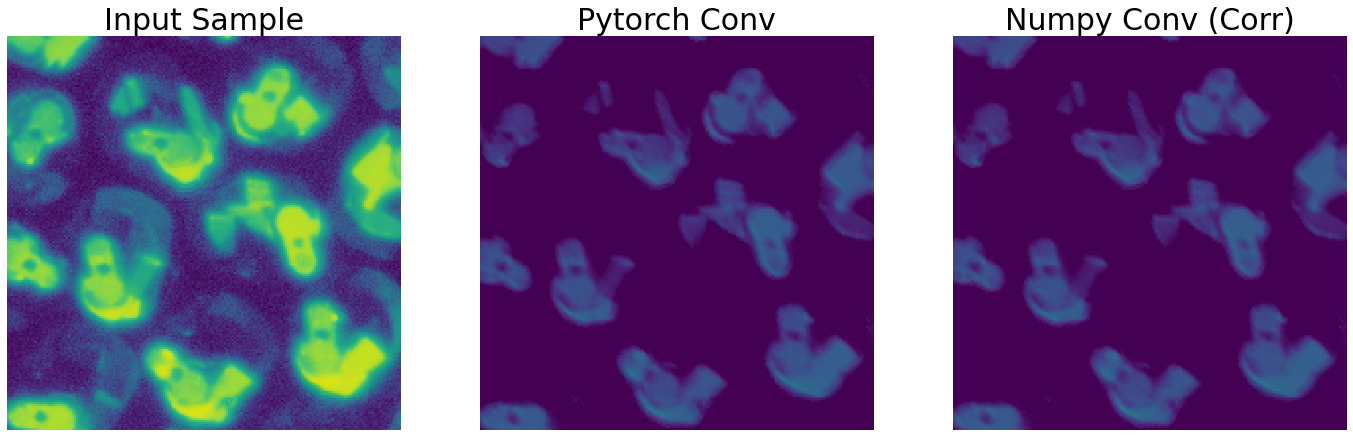

In [10]:
pytorch_numpy_comparison(input_data=sample,
                         pytorch_output=pytorch_out,
                         numpy_output=out,
                         sample_idx=0,
                         start=1400,
                         end=1600,
                         FFT=False)

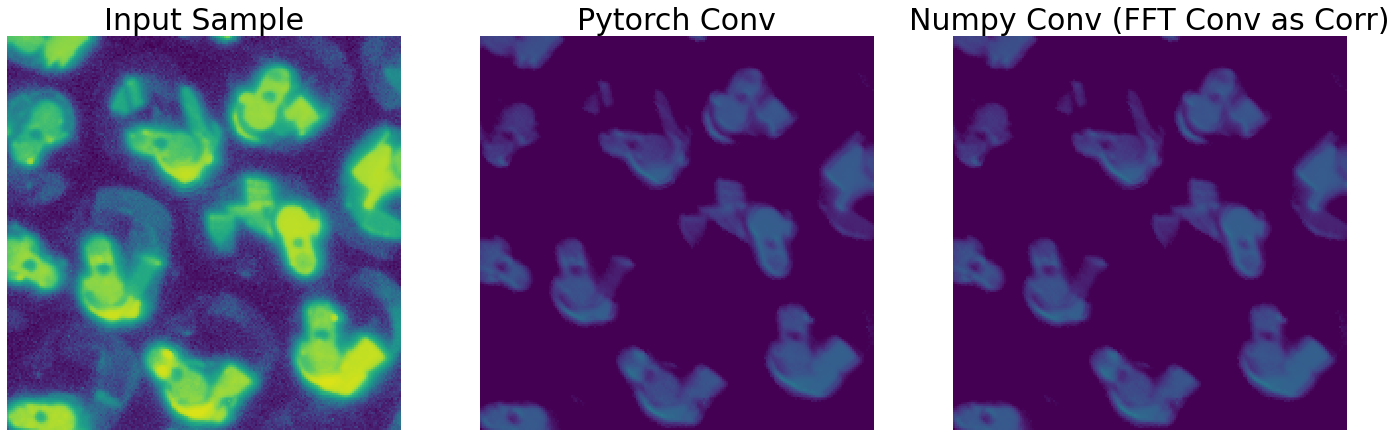

In [11]:
pytorch_numpy_comparison(input_data=sample,
                         pytorch_output=pytorch_out,
                         numpy_output=out,
                         sample_idx=0,
                         start=1400,
                         end=1600,
                         FFT=True)

## Commented code was just to see if the pytorch code above would be any different compared to the pytorch code I wrote for the inference of the whole pytorch model. There was no difference. `np.allclose` was `True` for the default values of `atol` & `rtol`

In [12]:
# test_sample = sample[:1]
# type(sample)
# # sample_torch = torch.from_numpy(sample)
# params = OrderedDict({'weight': weights['layers.0.0.weight'], 'bias': weights['layers.0.0.bias']})

# model = nn.Conv2d(in_channels=1, out_channels=58, kernel_size=3, stride=1, padding='same') # 1 input channel, 1 output channels, kernelsize=3, stride=1, padding=0
# model.to(device)
# model.load_state_dict(params)
# model.eval();

# with torch.no_grad():
    
#     torch.cuda.empty_cache()
#     test_sample = torch.as_tensor(test_sample)
#     test_sample = test_sample.to(device)
    
#     output = model(test_sample)
#     pytorch_out1 = output.detach().cpu().numpy()

# np.allclose(pytorch_out, pytorch_out1)

`absolute(a - b) <= (atol + rtol * absolute(b))`

In [13]:
# rtol=1e-05
# atol=1e-05

# a = pytorch_out
# b = out_fft

# left = np.abs(a - b)
# print(left[0][0][0][:5])
# right = atol + rtol * np.abs(b)
# print(right[0][0][0][:5])

# left <= right

# Testing speeds of numpy implementation of the batchnorm layer


Testing the speeds of `np_BatchNorm2d` to see if this is causing a long hangup

In [14]:
def np_BatchNorm2d(input_data, prefix, weights_dict, epsilon=1e-5):
    
    x = input_data
    
    load_gamma_start = time.perf_counter() 
    gamma = weights_dict[str(prefix) + 'weight'].detach().cpu().numpy().reshape(-1, 1, 1)
    load_gamma_end = time.perf_counter() 
    print('Loading gamma takes', load_gamma_end-load_gamma_start, 'seconds')
    
    load_beta_start = time.perf_counter()
    beta = weights_dict[str(prefix) + 'bias'].detach().cpu().numpy().reshape(-1, 1, 1)
    load_beta_end = time.perf_counter()
    print('Loading beta takes', load_beta_end-load_beta_start, 'seconds')
    
    load_mean_start = time.perf_counter()
    mean = weights_dict[str(prefix) + 'running_mean'].detach().cpu().numpy().reshape(-1, 1, 1)
    load_mean_end = time.perf_counter()
    print('Loading means take', load_mean_end-load_mean_start, 'seconds')
    
    load_var_start = time.perf_counter()
    var = weights_dict[str(prefix) + 'running_var'].detach().cpu().numpy().reshape(-1, 1, 1)
    load_var_end = time.perf_counter()
    print('Loading vars take', load_var_end-load_var_start, 'seconds')
        
    output_start = time.perf_counter()    
    output = ((x - mean) / np.sqrt(var + epsilon)) * gamma + beta
    output_end = time.perf_counter()
    print('Calculating batchnorm takes', output_end-output_start, 'seconds')
    
    return output

Seems to be a potential memory leak or something isn't being deleted. Note that the second convolution is almost ~20 seconds longer!

In [15]:
out_fft0 = fft_np_Conv2d(input_data=sample[0], weights_dict=weights, prefix='layers.0.0.')
out_fft1 = fft_np_Conv2d(input_data=out_fft0, weights_dict=weights, prefix='layers.1.0.')

out_norm = np_BatchNorm2d(input_data=out_fft1, weights_dict=weights, prefix='layers.1.1.')

Getting input dimensions takes 4.0879822336137295e-06 seconds
Loading the weights takes 0.0003163000219501555 seconds
Getting output dimensions takes 1.635198714211583e-05 seconds
Convolution loop takes 49.65356080402853 seconds
Getting input dimensions takes 2.435001078993082e-06 seconds
Loading the weights takes 0.0007681619608774781 seconds
Getting output dimensions takes 2.6751018594950438e-05 seconds
Convolution loop takes 66.09914485597983 seconds
Loading gamma takes 0.0004523330135270953 seconds
Loading beta takes 0.00013605202548205853 seconds
Loading means take 0.00012985104694962502 seconds
Loading vars take 0.00014051096513867378 seconds
Calculating batchnorm takes 11.928697594965342 seconds


This PyTorch block below represents the first few layers in DnCNN ie. Conv + Conv + Batch

In [16]:
test_sample = sample[:1]
test_sample = torch.as_tensor(test_sample)
test_sample = test_sample.to(device)

# First layer of DnCNN
params = OrderedDict({'weight': weights['layers.0.0.weight'], 'bias': weights['layers.0.0.bias']})

model = nn.Conv2d(in_channels=1, out_channels=58, kernel_size=3, stride=1, padding='same') # 1 input channel, 1 output channels, kernelsize=3, stride=1, padding=0
model.to(device)
model.load_state_dict(params)
pytorch_out = model(test_sample)

# Start of second layer block.
# First in block is conv layer.
params = OrderedDict({'weight': weights['layers.1.0.weight'], 'bias': weights['layers.1.0.bias']})

model = nn.Conv2d(in_channels=58, out_channels=58, kernel_size=3, stride=1, padding='same') # 1 input channel, 1 output channels, kernelsize=3, stride=1, padding=0
model.to(device)
model.load_state_dict(params)
pytorch_out = model(pytorch_out)

# Start of second layer block.
# Second in block is batchnorm layer
test_sample = test_sample.to(device)
params = OrderedDict({'weight': weights['layers.1.1.weight'], 'bias': weights['layers.1.1.bias'], 'running_mean': weights['layers.1.1.running_mean'], 'running_var': weights['layers.1.1.running_var']})

model = nn.BatchNorm2d(num_features=58) # 1 input channel, 1 output channels, kernelsize=3, stride=1, padding=0
model.to(device)
model.load_state_dict(params)

# Don't forget to change BatchNorm to eval mode!
model.eval()
with torch.no_grad():
    pytorch_norm_out = model(pytorch_out)
    pytorch_norm_out = pytorch_norm_out.detach().cpu().numpy()

In [17]:
np.isclose(out_norm, pytorch_norm_out)

array([[[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],

        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],

        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, Fa

In [18]:
np.allclose(out_norm, pytorch_norm_out, rtol=1, atol=1)

False

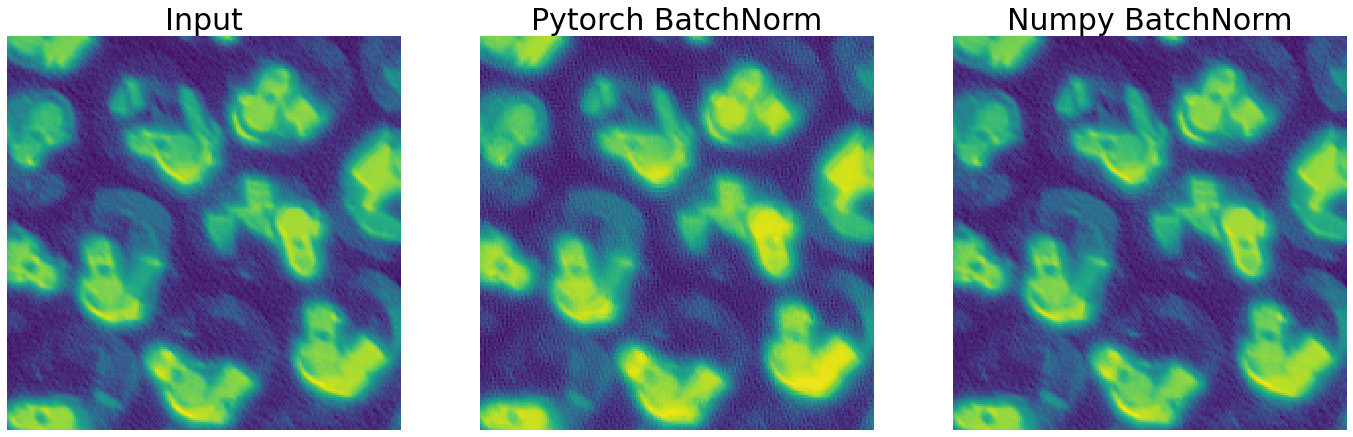

In [19]:
# This isn't using vmin/vmax due the plots of the BatchNorm's
# being completely washed out

# This is the input to BatchNorm after going through 2 Conv layers
pytorch_numpy_comparison(input_data=out_fft1,
                         pytorch_output=pytorch_norm_out,
                         numpy_output=out_norm,
                         sample_idx=0,
                         start=1400,
                         end=1600,
                         conv = False,
                         FFT = True)

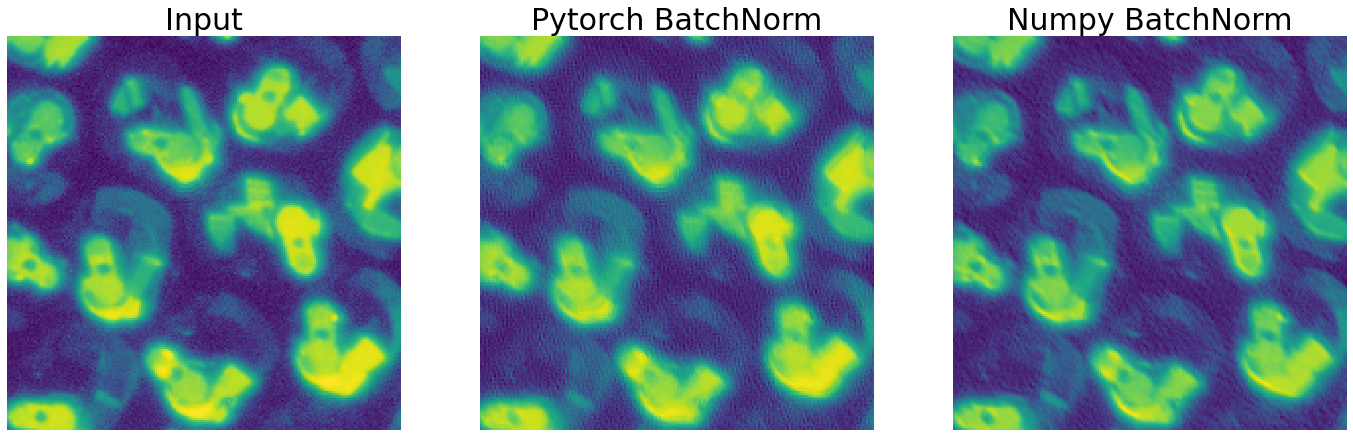

In [20]:
# This isn't using vmin/vmax due the plots of the BatchNorm's
# being completely washed out

# This is the actual input image
pytorch_numpy_comparison(input_data=sample[:1],
                         pytorch_output=pytorch_norm_out,
                         numpy_output=out_norm,
                         sample_idx=0,
                         start=1400,
                         end=1600,
                         conv = False,
                         FFT = True)

# Testing the whole model, for fun...

In [21]:
out_fft0 = fft_np_Conv2d(input_data=sample[0], weights_dict=weights, prefix='layers.0.0.')

out_fft1 = fft_np_Conv2d(input_data=out_fft0, weights_dict=weights, prefix='layers.1.0.')
out_norm1 = np_BatchNorm2d(input_data=out_fft1, weights_dict=weights, prefix='layers.1.1.')
out = relu(out_norm1)

out = fft_np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.2.0.')
out_norm1 = np_BatchNorm2d(input_data=out, weights_dict=weights, prefix='layers.2.1.')
out = relu(out_norm1)

out = fft_np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.3.0.')
out_norm1 = np_BatchNorm2d(input_data=out, weights_dict=weights, prefix='layers.3.1.')
out = relu(out_norm1)

out = fft_np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.4.0.')
out_norm1 = np_BatchNorm2d(input_data=out, weights_dict=weights, prefix='layers.4.1.')
out = relu(out_norm1)

out = fft_np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.5.0.')
out_norm1 = np_BatchNorm2d(input_data=out, weights_dict=weights, prefix='layers.5.1.')
out = relu(out_norm1)

out = fft_np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.6.0.')
out_norm1 = np_BatchNorm2d(input_data=out, weights_dict=weights, prefix='layers.6.1.')
out = relu(out_norm1)

out = fft_np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.7.0.')
out_norm1 = np_BatchNorm2d(input_data=out, weights_dict=weights, prefix='layers.7.1.')
out = relu(out_norm1)

out = fft_np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.8.0.')
out_norm1 = np_BatchNorm2d(input_data=out, weights_dict=weights, prefix='layers.8.1.')
out = relu(out_norm1)

out = fft_np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.9.0.')
out_norm1 = np_BatchNorm2d(input_data=out, weights_dict=weights, prefix='layers.9.1.')
out = relu(out_norm1)

out = fft_np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.10.0.')
out_norm1 = np_BatchNorm2d(input_data=out, weights_dict=weights, prefix='layers.10.1.')
out = relu(out_norm1)

out = fft_np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.11.0.')
out_norm1 = np_BatchNorm2d(input_data=out, weights_dict=weights, prefix='layers.11.1.')
out = relu(out_norm1)

out = fft_np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.12.0.')
out_norm1 = np_BatchNorm2d(input_data=out, weights_dict=weights, prefix='layers.12.1.')
out = relu(out_norm1)

out = fft_np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.13.0.')
out_norm1 = np_BatchNorm2d(input_data=out, weights_dict=weights, prefix='layers.13.1.')
out = relu(out_norm1)

out = fft_np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.14.0.')
out_norm1 = np_BatchNorm2d(input_data=out, weights_dict=weights, prefix='layers.14.1.')
out = relu(out_norm1)

out = fft_np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.15.0.')
out_norm1 = np_BatchNorm2d(input_data=out, weights_dict=weights, prefix='layers.15.1.')
out = relu(out_norm1)

out = fft_np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.16.0.')
out_norm1 = np_BatchNorm2d(input_data=out, weights_dict=weights, prefix='layers.16.1.')
out = relu(out_norm1)

out = fft_np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.17.0.')
out_norm1 = np_BatchNorm2d(input_data=out, weights_dict=weights, prefix='layers.17.1.')
out = relu(out_norm1)

out = fft_np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.18.0.')
out_norm1 = np_BatchNorm2d(input_data=out, weights_dict=weights, prefix='layers.18.1.')
out = relu(out_norm1)

resid_img = fft_np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.19.')

denoised = sample[0] - resid_img

Getting input dimensions takes 4.809990059584379e-06 seconds
Loading the weights takes 0.0005423360271379352 seconds
Getting output dimensions takes 1.9367027562111616e-05 seconds
Convolution loop takes 48.96264704497298 seconds
Getting input dimensions takes 3.828026819974184e-06 seconds
Loading the weights takes 0.0002261169720441103 seconds
Getting output dimensions takes 3.1080038752406836e-05 seconds
Convolution loop takes 66.89234363200376 seconds
Loading gamma takes 0.00012981100007891655 seconds
Loading beta takes 0.0003200970240868628 seconds
Loading means take 0.00013936898903921247 seconds
Loading vars take 0.0001435269950889051 seconds
Calculating batchnorm takes 11.257159533037338 seconds
Getting input dimensions takes 3.667024429887533e-06 seconds
Loading the weights takes 0.0005581069854088128 seconds
Getting output dimensions takes 3.239203942939639e-05 seconds
Convolution loop takes 67.27896877599414 seconds
Loading gamma takes 0.00013340701116248965 seconds
Loading be

Text(0.5, 1.0, 'Numpy Denoised')

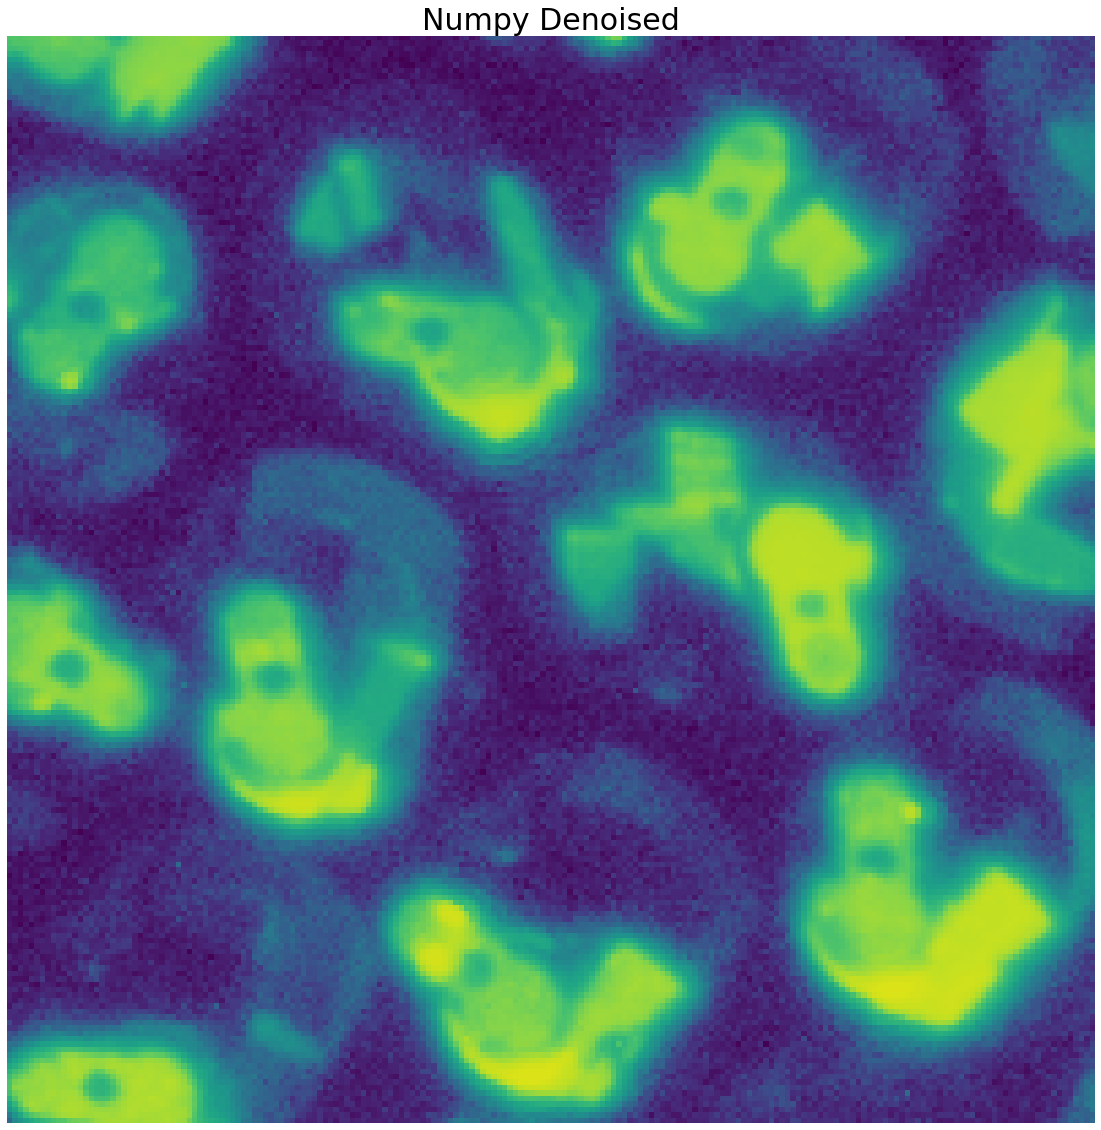

In [23]:
start=1400
end=1600

fig, ax = plt.subplots(1, 1, figsize=(24,20))
vmin, vmax = np.percentile(denoised, (1,99))

ax.imshow(denoised[0][0][start:end, start:end],vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
ax.axis('off')
ax.set_title('Numpy Denoised', fontsize=30)

In [25]:
sl.NERSC_save('first_numpy_denoise.npy', denoised)